# GAN (Réseaux Génératifs Antagonistes)
Nous souhaitons utiliser le même ensemble de données que celui que nous avons utilisé pour le jeu de données MINST des chiffres manuscrits.

### MINST Dataset

La base de données MNIST (Modified National Institute of Standards and Technology) est une vaste collection de chiffres manuscrits. Elle comprend un ensemble d'entraînement de 60 000 exemples et un ensemble de test de 10 000 exemples. Il s'agit d'un sous-ensemble de la base de données spéciale NIST 3 (chiffres écrits par des employés du Bureau du recensement des États-Unis) et de la base de données spéciale NIST 1 (chiffres écrits par des lycéens), qui contiennent des images monochromes de chiffres manuscrits. Les chiffres ont été normalisés en taille et centrés dans une image de taille fixe. Les images noir et blanc (bichromes) d'origine de la NIST ont été normalisées en taille pour s'adapter à une boîte de 20x20 pixels tout en préservant leur rapport hauteur/largeur. Les images résultantes contiennent des niveaux de gris en raison de la technique d'anti-aliasing utilisée par l'algorithme de normalisation. Les images ont été centrées dans une image de 28x28 en calculant le centre de masse des pixels, puis en déplaçant l'image de manière à positionner ce point au centre du champ de 28x28 pixels.

![](https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png)
# Importer des bibliothèques

## Importer l'ensemble de données MNIST

## Explorer les données de traitement

## Prétraitement des données

Pour vérifier que les données sont dans le format correct et que vous êtes prêt à construire et entraîner le réseau, affichons les 20 premières images de l'*ensemble d'entraînement* et affichons le nom de classe sous chaque image.

## Construction du modèle

### Discriminateur
Il s'agit du même modèle que celui que nous avons créé la semaine dernière. Je ne rentre pas dans les détails du modèle car cela nécessite une connaissance plus approfondie, mais considérez toujours que le modèle vous est donné.

In [ ]:
discriminator = Sequential(name="discriminator")
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))



discriminator.summary()


### Generator

In [ ]:
generator = Sequential(name="generator")
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))


generator.summary()


Maintenant, nous allons créer notre réseau GAN simple.
![](https://developer.ibm.com/developer/default/articles/generative-adversarial-networks-explained/images/GANs.jpg)

In [ ]:
GAN =Sequential([generator,discriminator])
GAN.summary()


### Compiler les modèles

#### Compiler discriminator

In [ ]:
discriminator.compile(optimizer='adam',loss='binary_crossentropy')

#### Compiler le générateur
⚠️ Nous n'avons pas besoin de compiler le générateur seul ! Au lieu de cela, nous pouvons compiler l'ensemble du réseau GAN en informant le réseau qu'il ne doit pas entraîner la partie du discriminateur. C'est exactement la même chose mais c'est plus facile à entraîner puisque nous avons les deux parties ensemble.

In [ ]:
discriminator.trainable = False
GAN.compile(optimizer='adam',loss='binary_crossentropy')

## Entraîner le modèle

La phase d'entraînement à chaque étape se compose de deux parties : l'entraînement du discriminateur, puis la fixation du discriminateur et l'entraînement du générateur.

C'est parti :

Avant de commencer, pour faciliter l'affichage, nous voulons utiliser la bibliothèque tqdm pour montrer la progression de l'entraînement.
Ajoutez `from tqdm.auto import tqdm`
puis à n'importe quel endroit où vous voulez afficher la barre de progression, vous pouvez l'encadrer avec `tqdm()`

Par exemple, au lieu de `range(10)`, vous pouvez utiliser `tqdm(range(10))`.

In [ ]:
epochs = 30
batch_size = 100
noise_shape=100

for epoch in tqdm(range(epochs),desc="epochs"):   
    for i in tqdm(range(X_train.shape[0]//batch_size),desc=f"batchs in epoch {epoch}"):
            
        random_input=np.random.normal(size=[batch_size,noise_shape]) # Generate random values
       
        fake_images = generator.predict_on_batch(random_input) # use the random values to generate new images
        
        real_train_dataset = X_train[i*batch_size:(i+1)*batch_size] # select a subset of dataset
       
        #training discriminator on real images
        real_train_label=np.ones(shape=(batch_size,1)) # all labels are 1 since all are real
        discriminator.trainable = True # Now we want train the discriminator
        d_loss_real=discriminator.train_on_batch(real_train_dataset,real_train_label)
        
        #training discriminator on fake images
        fake_train_label=np.zeros(shape=(batch_size,1)) # all fake images should be 0 in label why?
        d_loss_fake=discriminator.train_on_batch(fake_images,fake_train_label)
        
        ## Now we have trained discriminator let's go to train generator by fixing discriminator
        discriminator.trainable = False

        #training generator 
        random_input=np.random.normal(size=[batch_size,noise_shape])
        fooled_label=np.ones(shape=(batch_size,1))
        # why? because we want to train generator. our goal is to have all generated images classified as real image
        d_g_loss_batch =GAN.train_on_batch(random_input, fooled_label)
        
        
        
       
    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

        
        
print('Training is complete')

# Si lent ? --> Utilisez un GPU ! Pourquoi ?
En utilisant un GPU, vous pouvez accélérer considérablement le processus d'entraînement de votre modèle. Les GPU sont spécialement conçus pour effectuer des calculs parallèles, ce qui les rend extrêmement efficaces pour les tâches liées à l'apprentissage machine et à l'apprentissage profond.

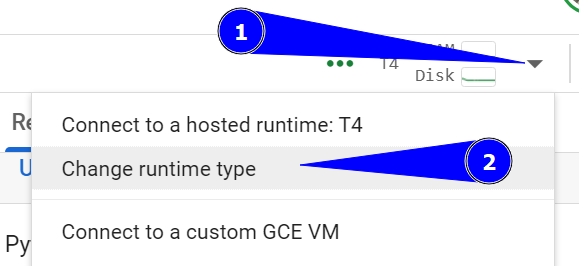
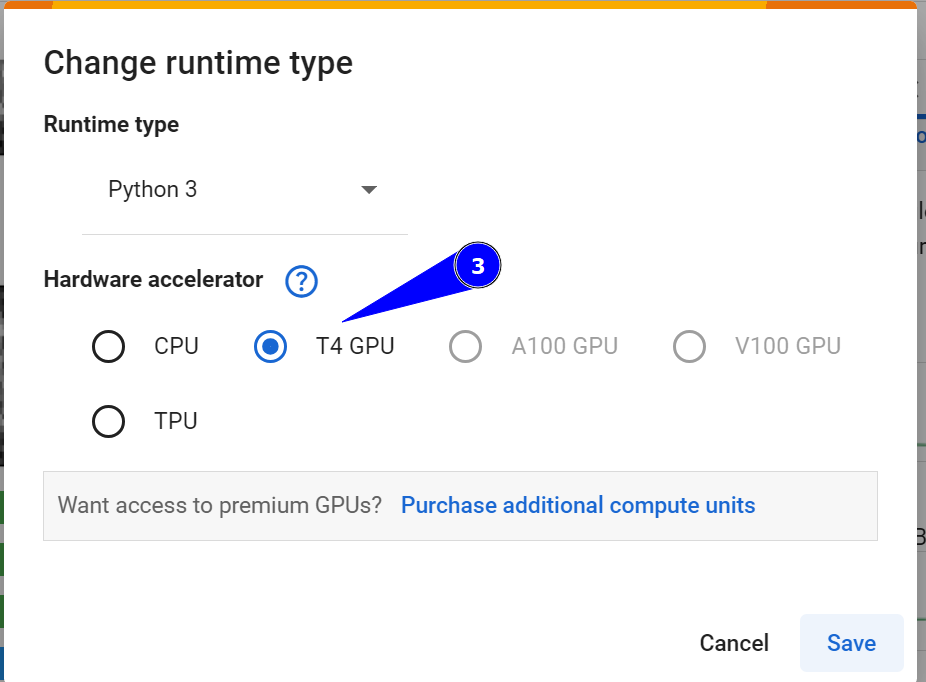

# Répétez le processus d'entraînement pendant 2000 epochs en GPU
Quelle est la qualité des images générées ?

# Afficher les données d'entrée

In [ ]:
input=np.random.normal(size=[10,noise_shape])
plt.imshow(input)
plt.title('How the input looks')

# Afficher les images générées

In [ ]:
gen_image = generator.predict(input)


fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1

# Meilleur modèle

Au lieu du modèle précédent, nous utiliserons Conv2D. Regardez la vidéo à l'adresse https://www.youtube.com/watch?v=JboZfxUjLSk

In [ ]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[100]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))


generator.summary()


In [ ]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))
discriminator.summary()


# Relancer avec le nouveau modèle


# Créez un modèle capable de générer uniquement votre nombre chance (entre 0 et 9)

Par exemple, si votre nombre chance est 7, le modèle devrait générer un 7 écrit à la main.